# **Self-checkout Stations: Efficiency and Fraud Prevention**

The prevalence of **self-checkout stations** in retail outlets is on the rise. There are two primary types:

- **Stationary self-checkouts**: Customers scan and pay for items in a specific area.
- **Semi-stationary checkouts**: Scanning occurs throughout the store using either customers' smartphones or store-provided devices, and payment is finalized at a counter.

This system enhances customer convenience by minimizing queues. However, it raises a critical question: `How can retailers prevent misuse of this trust-based system, and how can they identify fraudulent transactions without alienating honest customers?`

A prominent food retailer recently rolled out a **self-scanning system**, whereby shoppers use handheld mobile scanners to log their purchases. Despite its convenience, this type of payment system is vulnerable to fraud, with some customers potentially neglecting to scan certain items. Vendor research indicates that around **5% of self-scan transactions** exhibit discrepancies, although it's unclear whether these discrepancies result from intentional fraud, accidental errors, or scanner technical issues.

To limit losses, the retailer aims to detect fraud through **targeted follow-up checks**. The central challenge lies in striking a delicate balance: conducting enough checks to catch fraudulent activities without incurring unnecessary expenses or discouraging innocent customers due to false accusations. The overarching goal is to accurately identify as many faulty scans as possible.


<p align="center">
  <img width="460" height="300" src="https://www.nacsmagazine.com/nacsmagazine.com/images/styles/articles_detail_view_large/public/MAR22_NACS_Feat_Checkout_Main.png">
</p>

**Variable Description**:

| Column Name | Description | Value range |
|-------------|----------   |----------   |
| Trust Level |A customer’s individual trust level. 6: Highest trustworthiness   | {1,2,3,4,5,6} |
|Total Scan Time In Seconds  | Total time in seconds between the first and last product scanned   | Positive whole number   |
|Grand Total| Grand total of products scanned| Positive decimal number with maximum two decimal places|
|Line Item Voids|Number of voided scans|Positive whole number|
|Scans Without Registration|Number of attempts to activate the scanner without actually scanning anything|Positive whole number or 0|
|Quantity Modification|Number of modified quantities for one of the scanned products|Positive whole number or 0|
|Scanned Line Items Per Second|Average number of scanned products per second|Positive decimal number|
|Value Per Second| Average total value of scanned products per second|Positive decimal number|
|Line Item Voids Per Position| Average number of item voids per total number of all scanned and not cancelled products| Positive decimal number|
|Fraud|Classification as fraud (1) or not fraud (0)|{0,1}|


**Cost Sensitive Matrix**:

|               | actual 1 (fraud) | actual 0 (no fraud) |
|:------------:|:---------------:|:---------------:|
| **predicted 1 (fraud)** | 5 | -25 |
| **predicted 0 (no fraud)** | -5 | 0 |


The food retailer receives a profit of € 5 for every correctly identified fraud attempt. However, for every fraud case that goes unexposed he loses € 5.
A costumer falsely accused of fraud, might not return to this store, which is denoted by a € 25 loss for the retailer.
An honest customer identified correctly means neither profit nor loss for the retailer.
**`The goal is to get the max profit (reduce mis classification errors, especially false positive).`**

## 📚 1. Load Data and Overview

## 📊 2. EDA
- 🕵️‍♀️ 2.1 Fraud
- 🤝 2.2 Customer Trust Level
- 📦 2.3 Number of Items
- 🧮 2.4 Correlation Matrix
- 📈 2.5 Distribution Overview
- 📉 2.6 Scatter/Pair Plot

## 🤖 3. ML (detecting patterns)
- 💼 3.1 Import Libraries
- 🔄 3.2 Pre-process Dataset
- 🎚️ 3.3 PCA
- 🧩 3.4 Clustering
- 📊 3.5 Metric Selection

## 🔧 4. Model Building
- 🚂 4.1 Train Models
- 📊 4.2 Interpretation
- 🎯 4.3 Predictions
- 📜 4.4 Dummy Model
- 💾 4.5 Save the Model

# 1. Load data and overview

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import functions from util module 
from util import util

%autosave 1
%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds


In [44]:
#read train data
train = pd.read_csv('train.csv', sep='|')

In [45]:
# check the shape of the data
print(f'The number of rows in the data is {train.shape[0]} and the number of columns is {train.shape[1]}')

The number of rows in the data is 1879 and the number of columns is 10


*First, let's check if there are any missing values and werid data type*

In [4]:
train.isnull().sum().to_frame('Number of missing values').T

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
Number of missing values,0,0,0,0,0,0,0,0,0,0


In [5]:
train.dtypes.to_frame('Data type').T

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
Data type,int64,int64,float64,int64,int64,int64,float64,float64,float64,int64


*All looking good, let's proceed with EDA*

# 2. Data Visualization (EDA)

Get a better understanding of the data.

## 2.1 Fraud

*First, let's check the fraud distribution.*

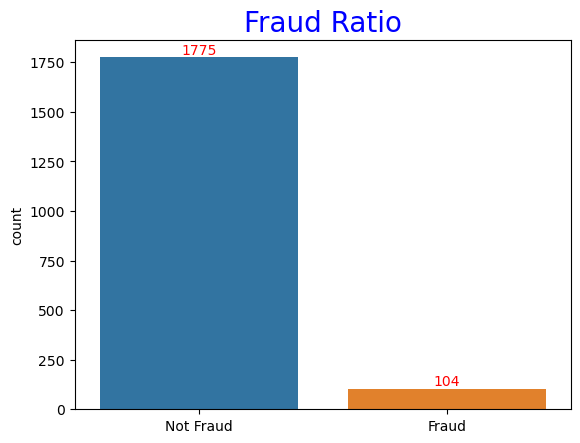

In [6]:
ax = sns.countplot(data=train, x='fraud')
plt.title('Fraud Ratio',size=20,color='blue')
ax.set_xticklabels(['Not Fraud', 'Fraud'])
plt.xlabel(None)

# Iterate through the bars and add the count label to each one
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=10, ha='center', va='bottom',color='red')

**Insights**:

The dataset is `highly imbalanced`, with a large majority of non-fraudulent examples and a small number of fraudulent ones. This could potentially impact the performance of a model built on this data, as it may not have sufficient examples of fraudulent behavior to accurately learn and classify it. To address this issue, we will need to consider techniques for mitigating the effects of imbalanced data during model building.

*Next, let's see if there are any correlations between the features and the target.*

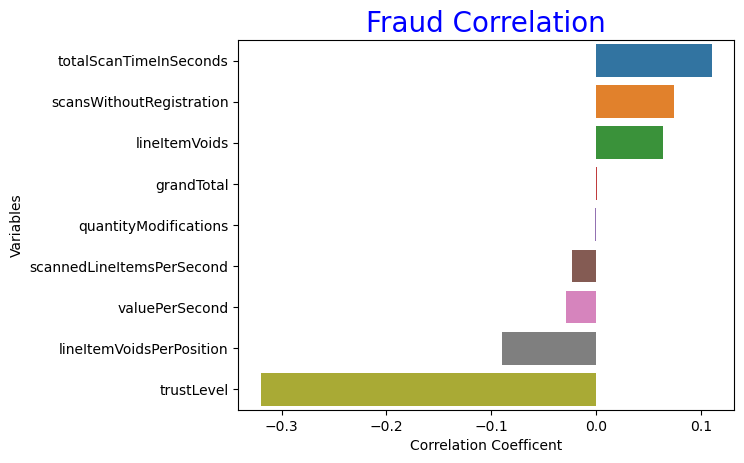

In [7]:
fraud_cor = train.corr()['fraud'].sort_values(ascending=False).to_frame().reset_index()[1:]
fraud_cor.columns = ['Variables','Correlation Coefficent']
sns.barplot(data=fraud_cor,y='Variables',x='Correlation Coefficent')
plt.title('Fraud Correlation',size=20,color='blue');

**Insights**:
* The total number of items appears to be better positively correlated with fraud than other variables, as shown in the graph. This suggests that the more items a customer purchases, the more likely they are to `make mistakes` or `engage in fraudulent activity`. This makes sense, as a larger number of items may increase the chances of errors being made, and individuals intending to commit fraud may try to purchase a large number of items in an attempt to go unnoticed for a several items that they do not scan.
* The correlation between trust level and fraud is strongest. This makes sense because customers with high trust levels are less likely to be involved in fraudulent activity.
* Overall, we can see that there is not a strong **Linear correlation** between the features and the target. This suggests that a linear model may not be the best choice for this data. Non-linear models may be more appropriate, as they can capture more complex relationships between the features and the target.

## 2.2 Customer Trust Level

A customer’s individual trust level.\
6: Highest trustworthiness \
1: Lowest trustworthiness

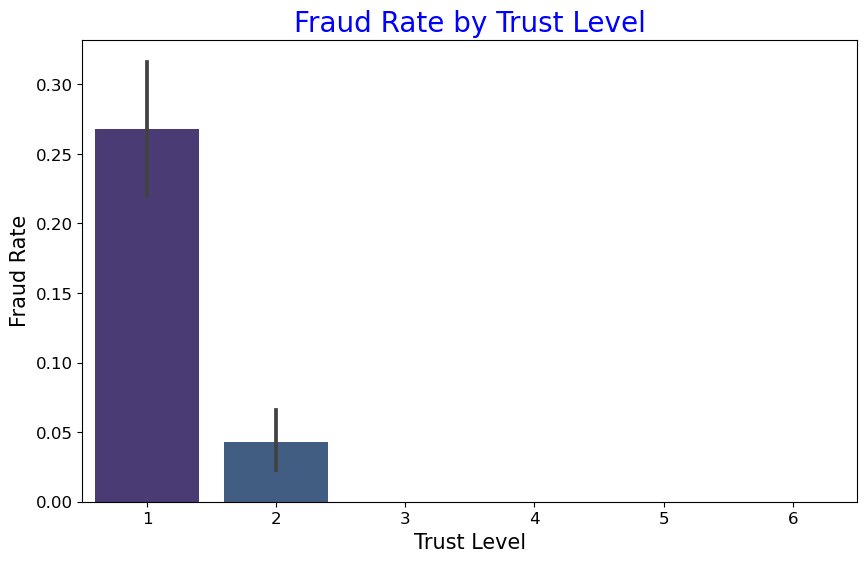

In [8]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x='trustLevel', y='fraud', data=train, palette='viridis')  # Set the color palette

plt.title('Fraud Rate by Trust Level', fontsize=20, color='blue')  # Add a title
plt.xlabel('Trust Level', fontsize=15)  # Add x-axis label
plt.ylabel('Fraud Rate', fontsize=15)  # Add y-axis label

plt.xticks(fontsize=12)  # Set the fontsize of x-axis ticks
plt.yticks(fontsize=12)  # Set the fontsize of y-axis ticks

plt.show()

**Insights and Strategies for Handling Imbalanced Data:**

1. **Distribution of Trust Levels Among Customers:** The dataset exhibits an equal distribution of customers across different trust levels. 

2. **Association of Fraud with Lower Trust Levels:** Notably, there is a pronounced prevalence of fraudulent activities among customers with lower trust levels. This aligns with the theoretical assumption that individuals with lower trust scores may be more inclined towards fraudulent behavior.

3. **Strategic Approach to Data Imbalance:**
   - **Selective Focus on Critical Trust Levels:** To address the issue of data imbalance, a viable strategy could be to exclude trust levels 5 and 6 in future fraud detection models. These levels appear to contribute minimally to identifying fraud. 
   - **Inclusion of Intermediate Trust Levels:** Retaining customers with trust levels 3 and 4 is advisable, as they represent a potential risk group for fraudulent activities.
   - **Model Application:** In practical scenarios, applying a model trained specifically on trust levels 1, 2, 3, and 4 could enhance the accuracy of fraud detection. This targeted approach would likely reduce misclassification errors, particularly false positives, which are crucial for maintaining customer trust, especially among those categorized at higher trust levels (5 and 6).

4. **Ongoing Monitoring for Comprehensive Safety:**
   - Despite focusing the model on lower trust levels, it's essential to continuously monitor for potential fraud occurrences within the higher trust levels (5 and 6). This could be effectively managed through a dedicated dashboard, ensuring a holistic and proactive fraud detection system. 

## 2.3 Number of Items

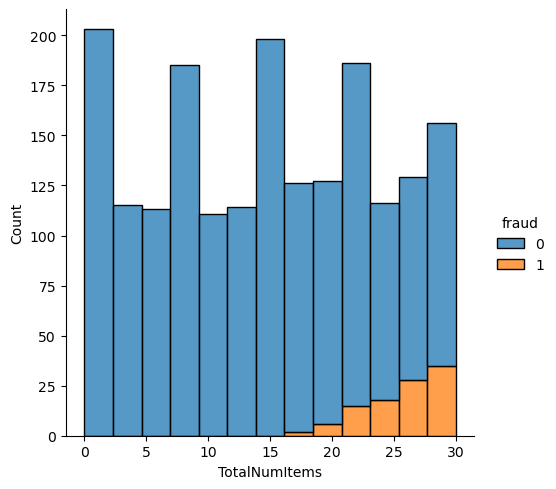

In [9]:
item_plt = train.copy()
item_plt['TotalNumItems'] = item_plt['totalScanTimeInSeconds'] * train['scannedLineItemsPerSecond']
item_plt['TotalNumItems'] = item_plt['TotalNumItems'].astype('int64')

sns.displot(data=item_plt, x='TotalNumItems',hue='fraud',multiple='stack');

**Insights**:
* Yes. It is similar to the fraud correlation chart. Both suggest that the more products a customer purchases, the more likely they are to commit fraud, regardless of whether the fraud is intentional or not (could due to mistake or technical issues).

## 2.4 Correlation Matrix

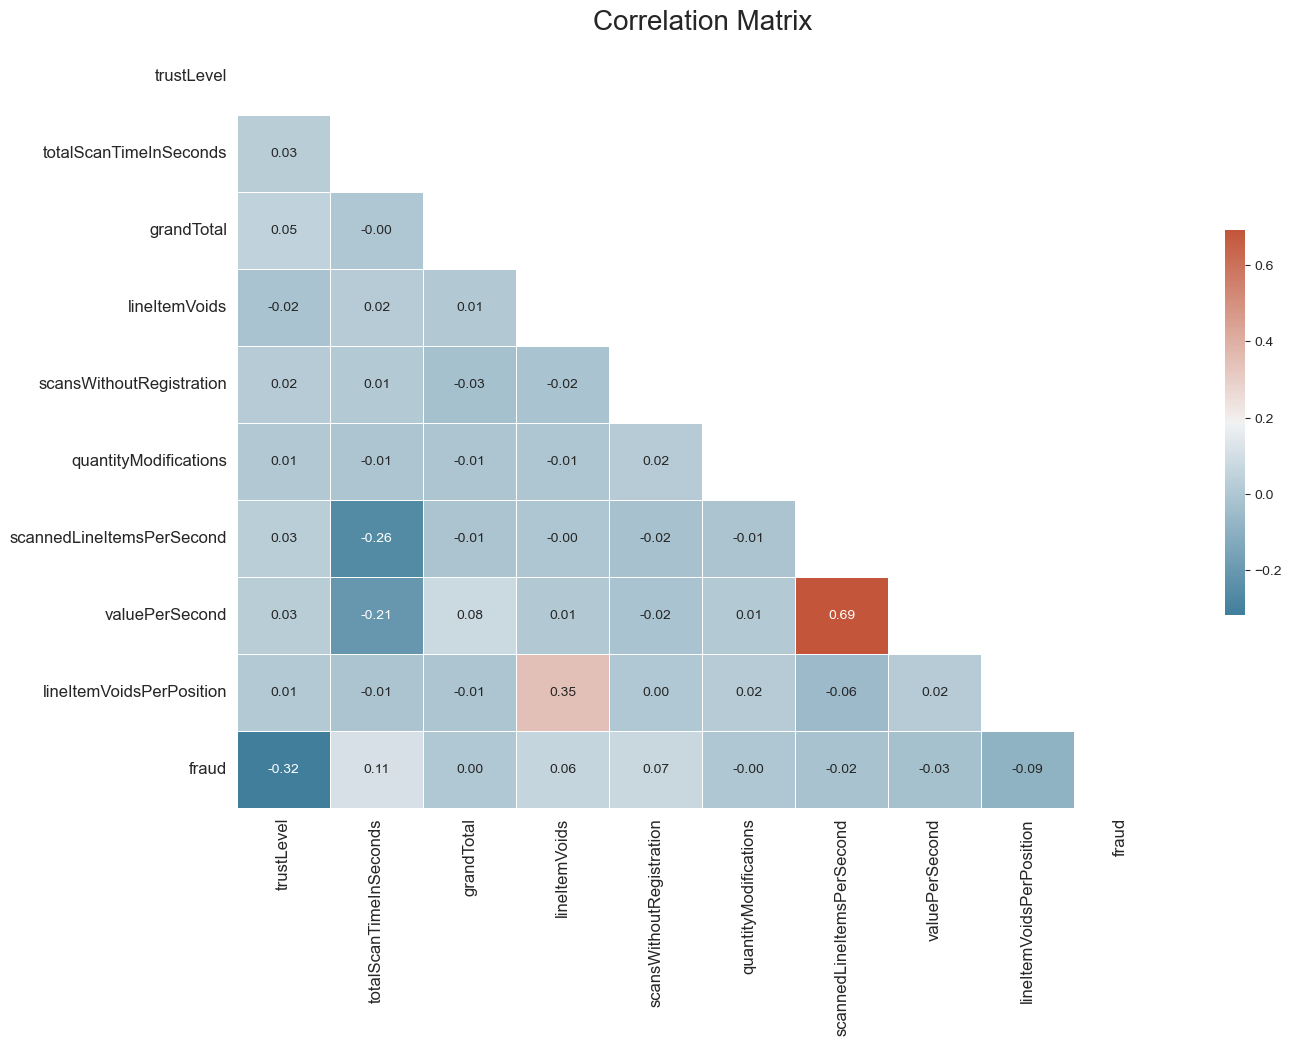

In [10]:
plt.figure(figsize=(15,10))
sns.set_style("white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train.corr(), dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(train.corr(), annot=True, mask=mask, cmap=cmap, fmt=".2f", 
            cbar_kws={"shrink": .5}, linewidths=.5)

plt.title("Correlation Matrix", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Insights**:

From a business perspective, this correlation matrix tells us several things:

1. The variable 'trustLevel' has a strong negative correlation with 'fraud', indicating that as trust level increases, the likelihood of fraud decreases. This makes sense as trustworthy customers are less likely to commit fraud.

2. 'totalScanTimeInSeconds' has a positive correlation with 'fraud', suggesting that longer scan times might be associated with fraudulent activities.

3. 'scannedLineItemsPerSecond' and 'valuePerSecond' are strongly correlated. This may mean that the faster items are scanned, the higher the transaction value per second, which could be due to bulk purchases or faster scanning of high-value items.

4. 'lineItemVoidsPerPosition' and 'lineItemVoids' have a strong positive correlation, which indicates that more line item voids could be associated with higher voids per position. This relationship might need further investigation.

5. Most other correlations are close to zero, suggesting no `significant linear relationship` between those pairs of variables.

Please note that correlation doesn't imply causation, and these interpretations are based on the assumption that the correlations are statistically significant. Further statistical testing and analysis may be required to validate these insights.

## 2.5 Distribution Overview

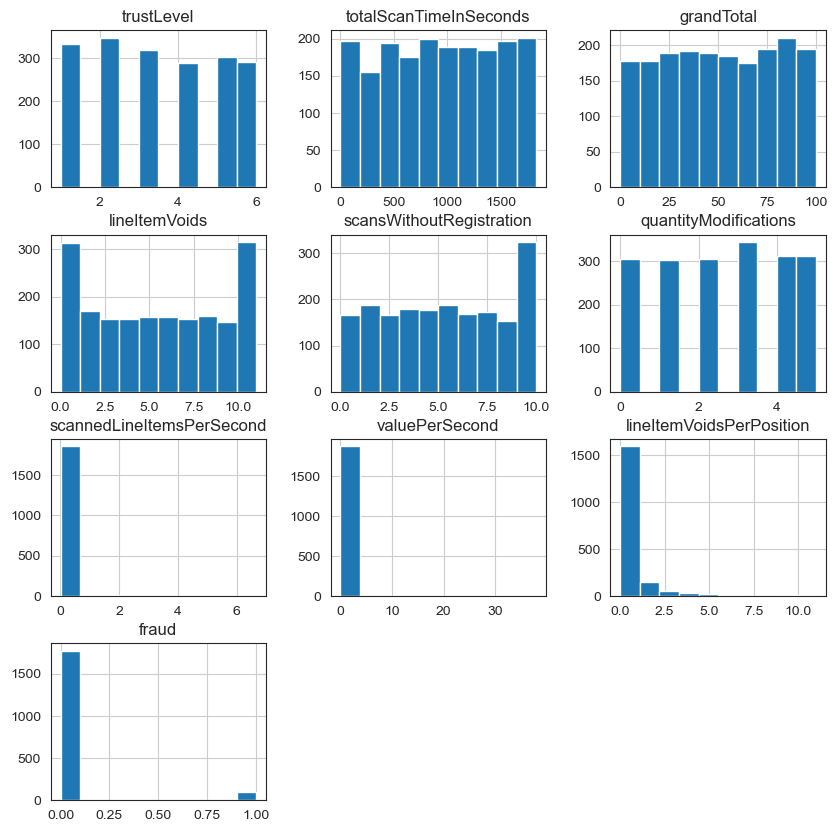

In [11]:
train.hist(figsize=(10, 10));

**Insights and Considerations for Data Distribution Analysis:**
- *Skewness in Key Variables:* The variables 'scannedlineitemspersecond', 'valuepersecond', and 'lineitemvoidsperposition' exhibit a right-skewed distribution. This skewness is characterized by a longer tail extending towards the right side of their respective distributions.

# 3. Machine Learning (detecting patterns and building a fraud detection model)

**import important libraries**

**Pre-process dataset**

In [12]:
help(util.pre_process)

Help on function pre_process in module util.util:

pre_process(data, activate=False, scaler=False)
    Preprocesses the data by filtering out certain trust levels <= 4, creating dependent and independent variables,
    scaling numeric columns, and creating dummy variables for categorical columns.
    
    Parameters:
    data (DataFrame): The data to be preprocessed.
    
    Returns:
    X (DataFrame): The preprocessed independent variables.
    y (Series): The dependent variable 'fraud'.



In [13]:
# get the independent and dependent variables for only trust level 1,2
X,y = util.pre_process(train, activate=False)

## Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from graphviz import Source
from sklearn.tree import _tree

In [15]:
print(f'Fruad percentage in the data is {round(y.mean()*100,2)}%')

Fruad percentage in the data is 5.53%


In [16]:
clf = DecisionTreeClassifier(class_weight={0:0.05,1:0.95},
                             min_impurity_decrease=0.001,
                             max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95}, max_depth=3,
                       min_impurity_decrease=0.001)

In [17]:
tree.export_graphviz(clf,
                    out_file='tree.dot',
                    feature_names=X.columns.values,
                    filled=True,
                    rounded=True,
                    special_characters=True,
                    proportion=True,
                    rotate=False)

s = Source.from_file('tree.dot')

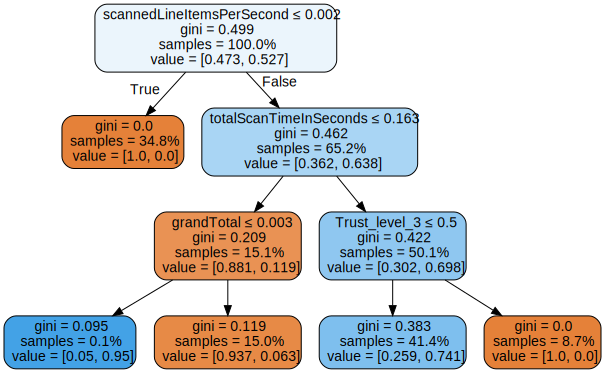

In [18]:
s

## PCA
PCA can help identify underlying patterns in the data that may not be immediately apparent when looking at the raw data.

In [19]:
from sklearn.decomposition import PCA

# Initiating PCA to reduce dimensions so that at least 80% variance is retained
pca = PCA(n_components=0.8)
pca.fit(X)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

PCA_ds = pd.DataFrame(pca.transform(X))

Number of components selected: 7
Total variance explained: 0.8224980479087143


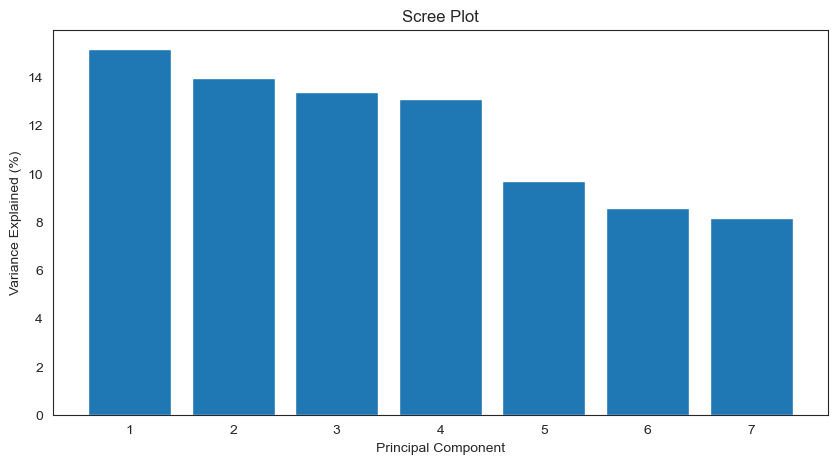

In [20]:
explained_variance = np.round(pca.explained_variance_ratio_*100, decimals=1)
components = range(1, pca.n_components_+1)

plt.figure(figsize=(10, 5))
plt.bar(components, explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot')
plt.show()

In [21]:
print(f'After we managed to reduce the dimensions, we now have {PCA_ds.shape[1]} features. Let us try to visualize them by applying clustering algorithms.')

After we managed to reduce the dimensions, we now have 7 features. Let us try to visualize them by applying clustering algorithms.


## Clustering
Clustering is a technique that can be used to group similar items together. In the context of customer data, clustering can be used to identify patterns, find insights about the customers and more importantly detect fraud.

Elbow Method to determine the number of clusters to be formed:


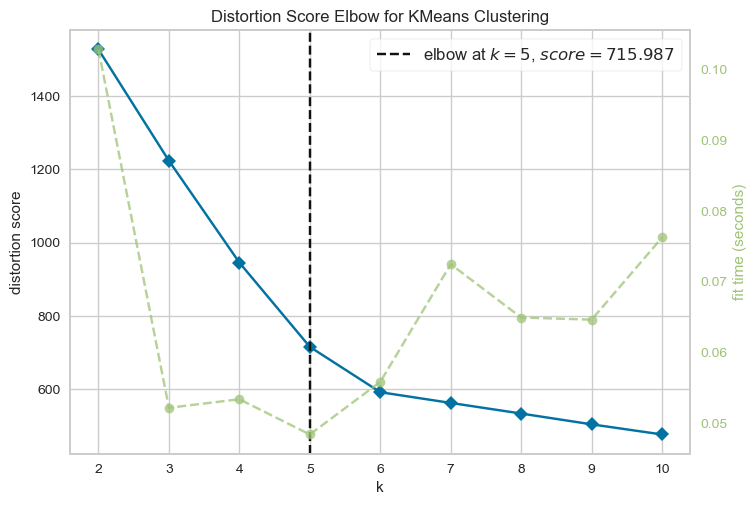

In [22]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# set a random seed to avoid getting different clusters each time
np.random.seed(42)

# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show();

In [23]:
# Get the optimal number of clusters
optimal_clusters = Elbow_M.elbow_value_
print(f"The optimal number of clusters is {optimal_clusters}")

The optimal number of clusters is 5


In [24]:
# Convert all column names to string
PCA_ds.columns = PCA_ds.columns.astype(str)

# Now, you can proceed with your existing code
data = train.copy()

# Initiate KMeans model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)

# Fit model and predict clusters
yhat_kmeans = kmeans.fit_predict(PCA_ds)

# Adding the Clusters feature to the original dataframe
data["Clusters"] = yhat_kmeans

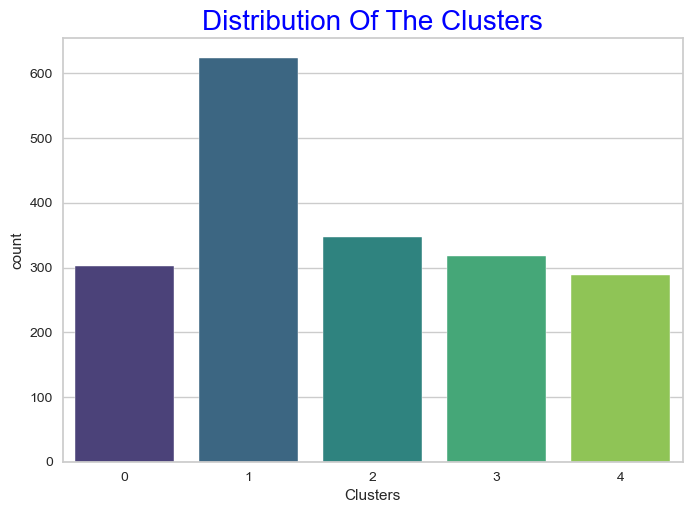

In [25]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters"], palette= 'viridis')
pl.set_title("Distribution Of The Clusters",size=20,color='blue')
plt.show()

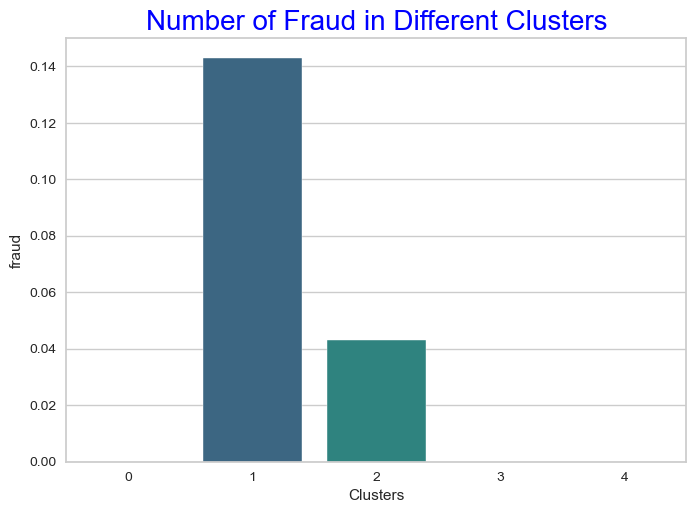

In [26]:
sns.barplot(y='fraud', x='Clusters', data=data, palette='viridis', ci=None)
plt.title("Number of Fraud in Different Clusters",size=20,color='blue');

In [27]:
fraud_per_cluster = data.groupby('Clusters')['fraud'].sum().sort_values(ascending=False)
top_2_clusters = fraud_per_cluster.head(2).index.tolist()

print("Top 2 clusters with the highest number of frauds:", top_2_clusters)

print(f"""
Insights:
- It is clear that clusters {top_2_clusters[0]} and {top_2_clusters[1]} account for the majority of fraudulent activity. 
- We can set up a pipeline that assigns new data points to these established clusters. If a new data point is assigned to either cluster {top_2_clusters[0]} or {top_2_clusters[1]}, there is an increased likelihood of fraud - this would be dependent on the proportions we found earlier. This part is added on the top of machine learning model. So, it's also important to develop a machine learning model to predict specific instances of fraud. 
- Let's examine the characteristics of clusters {top_2_clusters[0]} and {top_2_clusters[1]} to understand them better.
""")


Top 2 clusters with the highest number of frauds: [1, 2]

Insights:
- It is clear that clusters 1 and 2 account for the majority of fraudulent activity. 
- We can set up a pipeline that assigns new data points to these established clusters. If a new data point is assigned to either cluster 1 or 2, there is an increased likelihood of fraud - this would be dependent on the proportions we found earlier. This part is added on the top of machine learning model. So, it's also important to develop a machine learning model to predict specific instances of fraud. 
- Let's examine the characteristics of clusters 1 and 2 to understand them better.



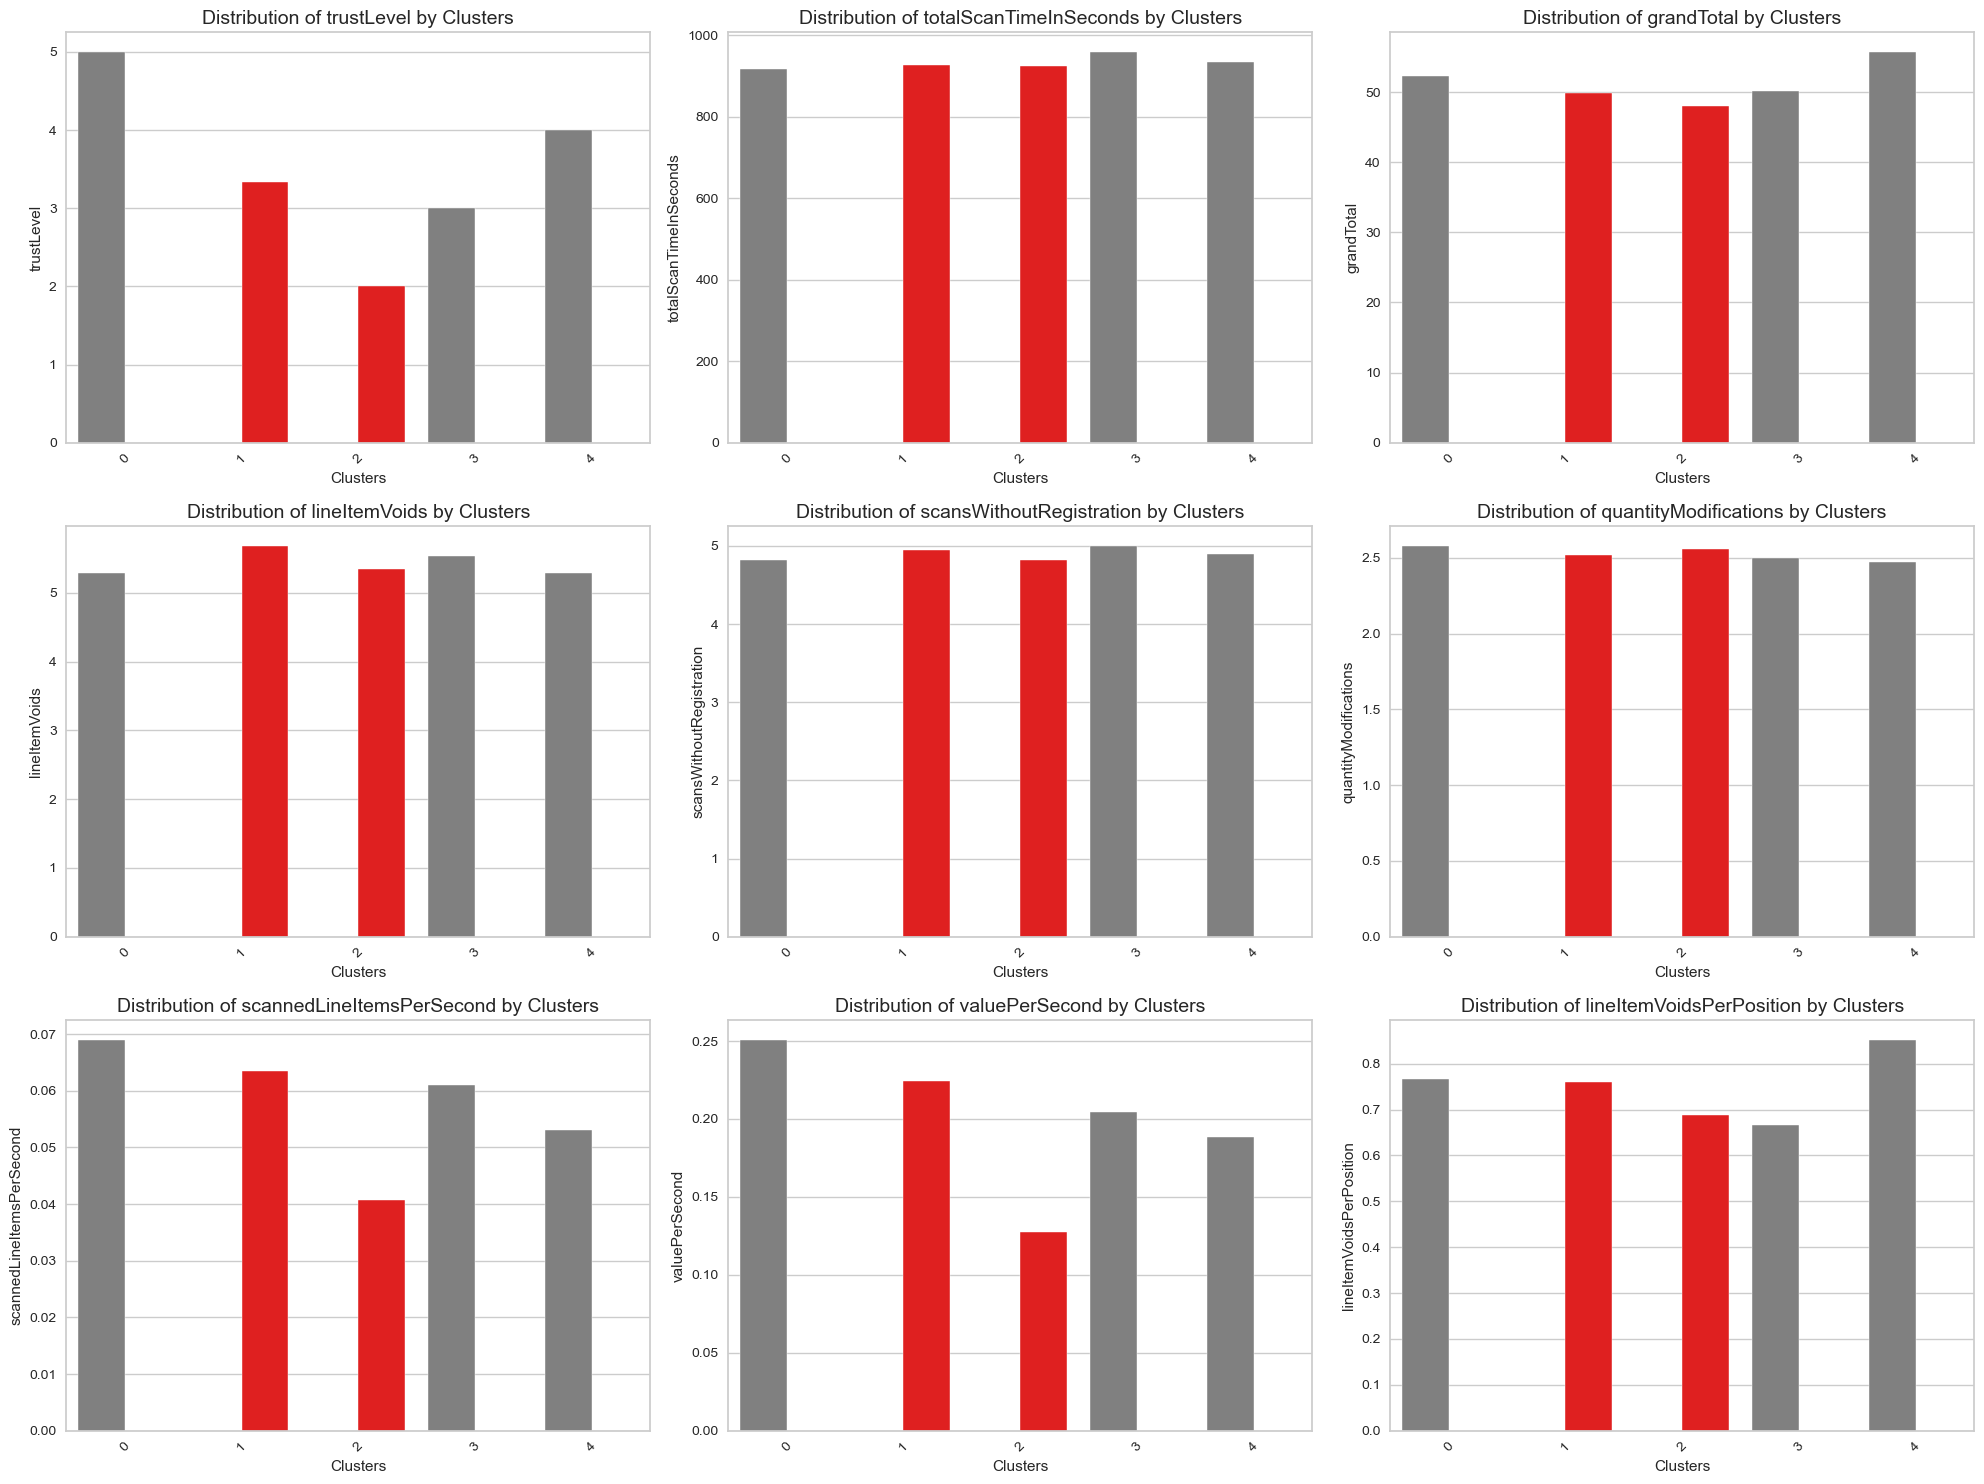

In [28]:
# Create a list of columns to plot, without 'fraud'
columns = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
           'scansWithoutRegistration', 'quantityModifications',
           'scannedLineItemsPerSecond', 'valuePerSecond',
           'lineItemVoidsPerPosition']

# Create a new feature in the DataFrame that marks clusters 0 and 4
data['highlight'] = np.where(data['Clusters'].isin(top_2_clusters), 'Highlight', 'Others')

# Set the number of rows and columns for the subplots
nrows = 3
ncols = 3

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

# Flatten the axes object to a single list of axes
axs = axs.flatten()

# Create a color palette
palette = {"Highlight": "red", "Others": "gray"}

# Iterate over the columns and plot each one
for ax, column in zip(axs, columns):
    sns.barplot(y=column, x='Clusters', hue='highlight', data=data, palette=palette, ax=ax, ci=None)
    ax.set_title(f"Distribution of {column} by Clusters", fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.get_legend().remove() # Remove the legend

# Tighten the layout 
plt.tight_layout()
plt.show()


**Metric Selection:**

Since we are dealing with an imbalanced dataset, relying solely on accuracy may not provide an accurate representation of the model's performance. Instead, we should consider using metrics such as the F1 score, recall, precision, and the confusion matrix. These metrics offer a more comprehensive evaluation of the model's ability to correctly classify instances from both classes, considering false positives, false negatives, true positives, and true negatives.

Additionally, when the dataset is imbalanced and false positive rate is of particular importance, it is advisable to pay attention to the PR (Precision-Recall) curve. This curve provides insights into the trade-off between precision and recall, allowing us to make more informed decisions during model selection.

**Models:**

We want a model that can not only predict wells but is also interpretable and can generate probabilities.
- Interpretability: When we suspect a person who commits fraud, we need a reason why that person commits fraud.
- We need a probability as it indicates likelihood.\
As a result, we might consider trying Logistic Regression, Tree-based models such as random forests, and XGBoost as they can generate interpretable feature importance and probabilities.

## Model Building

**Train models**

List of potential models:
- logistic
- RandomForecast Classifier
- XG Boost
- SVC 
- LGBM Classifier 

In [29]:
train

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
...,...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,1
1876,4,316,41.83,5,8,1,0.094937,0.132373,0.166667,0
1877,2,685,62.68,1,6,2,0.035036,0.091504,0.041667,0


[LightGBM] [Info] Number of positive: 104, number of negative: 1182
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 1286, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080871 -> initscore=-2.430572
[LightGBM] [Info] Start training from score -2.430572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 79, number of negative: 949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 11
[LightGBM] [Info]

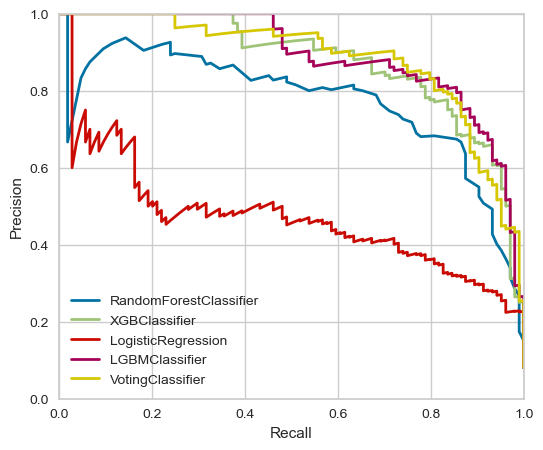

                    Model  Precision  Recall   AUC    F1
0  RandomForestClassifier       0.86    0.33  0.97  0.47
1           XGBClassifier       0.87    0.67  0.98  0.76
2      LogisticRegression       0.77    0.12  0.92  0.21
3          LGBMClassifier       0.84    0.75  0.99  0.80
4        VotingClassifier       0.94    0.53  0.99  0.68


In [30]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Assuming that data is loaded into a DataFrame 'train' and the target variable is 'fraud'
X,y = util.pre_process(train, activate=True)

models = [
    RandomForestClassifier(random_state=42),
    xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42),
    LogisticRegression(random_state=42),
    LGBMClassifier(random_state=42),
    VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                                    ('xgb', xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42)),
                                    ('gbc', GradientBoostingClassifier(random_state=42)),
                                    ('lr', LogisticRegression(random_state=42)),
                                    ('svc', SVC(random_state=42, probability=True)),
                                    ('lgbm', LGBMClassifier(random_state=42))],
                        voting='soft')
]

kf = KFold(n_splits=5, random_state=42, shuffle=True)

results = []

plt.figure(figsize=(6, 5))  # one figure for all models

for model in models:
    model.fit(X, y)
    y_scores = cross_val_predict(model, X, y, cv=kf, method="predict_proba")[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, y_scores)

    # Getting Precision, Recall and AUC with cross_val_score
    precision_score_val = cross_val_score(model, X, y, cv=kf, scoring='precision').mean()
    recall_score_val = cross_val_score(model, X, y, cv=kf, scoring='recall').mean()
    auc_score_val = roc_auc_score(y, y_scores)
    f1_score_val = 2 * (precision_score_val * recall_score_val) / (precision_score_val + recall_score_val)

    # Store the results
    results.append({'Model': model.__class__.__name__, 'Precision': precision_score_val, 'Recall': recall_score_val, 'AUC': auc_score_val, 'F1': f1_score_val})

    # PR Curve
    plt.plot(recall, precision, linewidth=2, label=model.__class__.__name__)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

# Create a DataFrame to display the results
# round the precision and recall values to 2 decimal places
results_df = pd.DataFrame(results).round(2)
print(results_df)

## 4. Predictions

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
X_pred = pd.read_csv('test.csv', sep='|')
y_pred = pd.read_csv('realclass.csv')

# Concetenate X_pred and y_pred 
testing_df = pd.concat([X_pred, y_pred], axis=1)

# filter out trust level 5 and 6 
testing_df_filtered_out_5_6 = testing_df[(testing_df['trustLevel'] != 5) & (testing_df['trustLevel'] != 6)].reset_index(drop=True)
testing_df_5_6 = testing_df[(testing_df['trustLevel'] == 5) | (testing_df['trustLevel'] == 6)].reset_index(drop=True)
X_pred = util.pre_process_test(testing_df_filtered_out_5_6.drop('fraud',axis=1))

In [34]:
# Calculate confusion matrix and other metrics
from sklearn.metrics import confusion_matrix

threshold = 0.5 
best_model = models[-1]

# Make predictions on the filtered dataset
probs = best_model.predict_proba(X_pred)
predictions = np.where(probs[:, 1] > threshold, 1, 0)

verify_data = pd.concat([testing_df_filtered_out_5_6[['fraud']], pd.DataFrame(predictions, columns=['pred'])], axis=1)
testing_df_5_6['pred'] = 0 
pred_final = pd.concat([verify_data, testing_df_5_6[['fraud','pred']]]).reset_index(drop=True)

confusion_mat = confusion_matrix(pred_final['fraud'], pred_final['pred'])

# Convert the confusion matrix to a DataFrame
confusion_df = pd.DataFrame(confusion_mat, 
                            index=['Actual no-Fraud', 'Actual Fraud'], 
                            columns=['Predicted no-Fraud', 'Predicted Fraud'])
confusion_df
# testing_df_filtered_out_5_6['pred'] = np.where(probs[:, 1] > threshold, 1, 0)


# Display the DataFrame
print(confusion_df)

# Calculate precision, recall, and accuracy
print(f"The precision score is {round(precision_score(testing_df_filtered_out_5_6['fraud'], predictions),2)}")
print(f"The recall score is {round(recall_score(testing_df_filtered_out_5_6['fraud'], predictions),2)}")
print(f"The accuracy score is {round((confusion_df.iloc[0,0] + confusion_df.iloc[1,1]) / confusion_df.sum().sum(),2)}")

                 Predicted no-Fraud  Predicted Fraud
Actual no-Fraud                1640              299
Actual Fraud                    447             1614
The precision score is 0.84
The recall score is 0.82
The accuracy score is 0.81


In [35]:
cost_true_positive = 5
cost_false_positive = -25
cost_false_negative = -5
cost_true_negative = 0

true_positive = confusion_mat[1][1]
false_positive = confusion_mat[0][1]
false_negative = confusion_mat[1][0]
true_negative = confusion_mat[0][0]

total_cost = (cost_true_positive * true_positive) + (cost_false_positive * false_positive) + (cost_false_negative * false_negative) + (cost_true_negative * true_negative)

print(total_cost)

-1640


Prediction distributions.

In [36]:
probs = probs[:,1]

# Define the bins
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Calculate the histogram
counts, _ = np.histogram(probs, bins=bins)

# Print the counts
for i in range(len(bins) - 1):
    print(f"Number of probs in [{bins[i]}, {bins[i+1]}]: {counts[i]}")

Number of probs in [0.1, 0.2]: 117
Number of probs in [0.2, 0.3]: 62
Number of probs in [0.3, 0.4]: 48
Number of probs in [0.4, 0.5]: 89
Number of probs in [0.5, 0.6]: 222
Number of probs in [0.6, 0.7]: 782
Number of probs in [0.7, 0.8]: 690
Number of probs in [0.8, 0.9]: 191
Number of probs in [0.9, 1.0]: 28


**Cost Sensitive Matrix**:

|               | actual 1 (fraud) | actual 0 (no fraud) |
|:------------:|:---------------:|:---------------:|
| **predicted 1 (fraud)** | 5 | -25 |
| **predicted 0 (no fraud)** | -5 | 0 |


That is: `The goal` is to minimize cost. 

*Cost Saving*

In [42]:
total_cost_without_ml = np.sum(confusion_mat[1] * -5)
total_cost_without_ml

-10305

In [38]:
saved_costs = np.abs(total_cost_without_ml - total_cost)
print(f'The Voting Classifier helps save around {saved_costs}')

The Voting Classifier helps save around 8665


## Model Interpretation

True


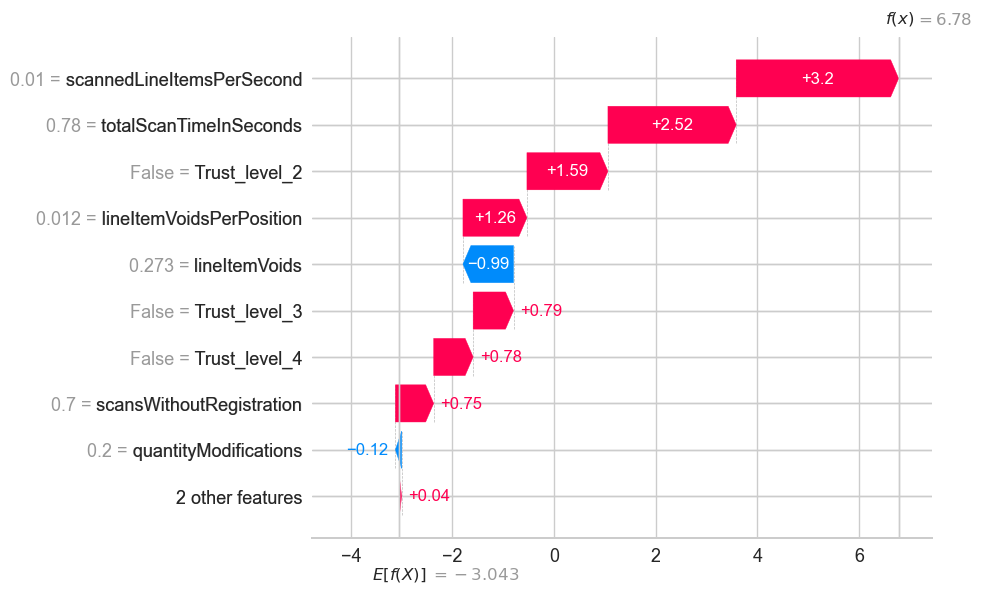

In [39]:
import shap

# Assuming model is an instance of an XGBoost model
model = models[1]  # Replace with your specific model

# Create a SHAP explainer - use TreeExplainer for tree-based models like XGBoost
explainer = shap.Explainer(model)

print(True if y_pred.iloc[0].values[0] == 1 else False) # check whether the instance is fraud or not

# Select a single instance to explain
X_instance = X_pred.iloc[[0]]  # Double square brackets to keep the DataFrame structure

# Calculate SHAP values for the selected instance
shap_values = explainer(X_instance)

# Generate the waterfall plot for the first instance
# Pass the entire Explanation object to the waterfall plot function
shap.plots.waterfall(shap_values[0])


## Save the Model

In [40]:
import pickle

# save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(models[-1], file)

In [41]:
## save the scaler

def pre_process(data):
    # import scaler 
    from sklearn.preprocessing import MinMaxScaler
    
    # Create dependent and independent variables
    X = data.drop('fraud',axis=1)
    X = X.reset_index(drop=True)
    y = data['fraud']

    # Set trustlevel to 'object'
    X['trustLevel'] = X['trustLevel'].astype('object')
    
    # select only the numeric columns
    numeric_columns = X.select_dtypes(include='number').columns
    X_numeric = X[numeric_columns]
    
    # create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # fit the scaler to the numeric columns and transform the data
    scaler.fit(X_numeric)
    
    return scaler

scaler = pre_process(train)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

## Thank you 